# Sliding Window Combined with CNN for padi field detection

# Preface

Original Article
**Using deep learning for padi field detection from Google Earth images.**

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

doi: https://doi.org/10.1101/351643

**Note**

Without using specialized  networks like U-net, but with a general CNN for classification, we still can perform a segmentation. The concept originates from the "Patch-based Classification", proposed in the following paper. See the slide below. Combining a sliding window patches with repatative CNN classification allows detection of the tumor region.

Watanabe et al., performed a similar approach to segment padi fields from satelite images retreived from google earth.
They express their method as "chopped images", however paying respect to the previous research, I describe this method as "Patch-based Classification" as I interpret the principle is identical. 


*Deep Learning for Identifying Metastatic Breast Cancer*

*Dayong Wang Aditya Khosla⋆ Rishab Gargeya Humayun Irshad Andrew H Beck Beth Israel Deaconess Medical Center, Harvard Medical School**
https://arxiv.org/abs/1606.05718
![image](https://raw.githubusercontent.com/totti0223/deep_learning_for_biologists_with_keras/master/assets/cancer.jpg)




# Import Libraries

In [1]:
!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from sklearn.utils.class_weight import compute_class_weight


Using TensorFlow backend.


# Download dataset

In [2]:
## Download and extract dataset
!wget https://raw.githubusercontent.com/Gio1709/paddy/master/padi.zip padi.zip
!unzip -P padi padi.zip


--2019-11-16 14:58:19--  https://raw.githubusercontent.com/Gio1709/paddy/master/padi.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3617849 (3.5M) [application/zip]
Saving to: ‘padi.zip’

padi.zip            100%[===================>]   3.45M  --.-KB/s    in 0.05s   

2019-11-16 14:58:20 (71.0 MB/s) - ‘padi.zip’ saved [3617849/3617849]

--2019-11-16 14:58:20--  http://padi.zip/
Resolving padi.zip (padi.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘padi.zip’
FINISHED --2019-11-16 14:58:20--
Total wall clock time: 0.9s
Downloaded: 1 files, 3.5M in 0.05s (71.0 MB/s)
Archive:  padi.zip
   creating: padi/
  inflating: padi/bamboopaddy_forest_detection.ipynb  
   creating: padi/chopped/
   creating: padi/test/
  inflating: padi/t

## Preview

In [3]:
!ls padi/train
#image names starting with "b" is image with only padi field.
#image names starting with "o" is image without padi field.

b10.jpg  b13.jpg  b2.jpg  b5.jpg  b8.jpg   o1.jpg  o4.jpg  o7.jpg
b11.jpg  b14.jpg  b3.jpg  b6.jpg  b9.jpg   o2.jpg  o5.jpg  o8.jpg
b12.jpg  b1.jpg   b4.jpg  b7.jpg  o10.jpg  o3.jpg  o6.jpg  o9.jpg


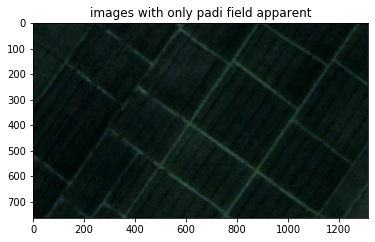

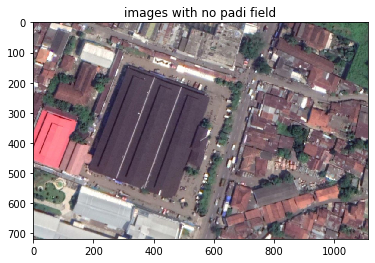

In [4]:
plt.title("images with only padi field apparent")
plt.imshow(imread("padi/train/b2.jpg"))
plt.show()

plt.title("images with no padi field")
plt.imshow(imread("padi/train/o10.jpg"))
plt.show()


# Create "patches" from each image using a sliding window

In [5]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #read imag from path save windows to the specified directory
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".jpg"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img)
        
files = os.listdir("padi/train/")
files = [x for x in files if x.endswith(".jpg")]

for file in files:
    save_directory = "padi/chopped"
    file = os.path.join("padi/train/",file)
    save_to_folder(file,save_directory)

/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: padi/chopped/b3_00002.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: padi/chopped/b3_00003.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: padi/chopped/b3_00004.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: padi/chopped/b3_00005.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: padi/chopped/b3_00006.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: padi/chopped/b3_00007.jpg is a low contrast image
  warn('%s is a low contr

In [6]:
files = os.listdir("padi/chopped/")
files = [x for x in files if x.endswith(".jpg")]

x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0
    
    img_path = os.path.join("padi/chopped",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

(12983, 56, 56, 3) (12983,)


In [33]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x,y,test_size=0.9,stratify = y)

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(1298, 56, 56, 3)
(1298,)
(11685, 56, 56, 3)
(11685,)


In [34]:
#compute class weight
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))

cw = compute_class_weight("balanced",np.unique(train_y),train_y)
print(cw)

(array([0, 1]), array([691, 607]))
(array([0, 1]), array([6218, 5467]))
[0.93921852 1.06919275]


# Build and Train CNN

In [35]:
model = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    layers.MaxPool2D((2,2),name="pool1"),
    #layers.Dropout(0.05),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    #layers.Dropout(0.05),
    layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    #layers.Dropout(0.05),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    #layers.Dropout(0.05),
    layers.Dense(1),
    layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 56, 56, 16)        448       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 28, 28, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 14, 14, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 32)       

In [36]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan model bobot yang terbaik selama training
ckpt = ModelCheckpoint("padi.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = model.fit(train_x,train_y,batch_size=50,epochs=100,validation_data=(valid_x,valid_y),class_weight=cw, callbacks = [ckpt])

Train on 1298 samples, validate on 11685 samples
Epoch 1/100
1298/1298 [==============================] - 2s 1ms/step - loss: 0.4902 - acc: 0.6980 - val_loss: 0.3591 - val_acc: 0.9311

Epoch 00001: val_loss improved from inf to 0.35906, saving model to padi.h5
Epoch 2/100
1298/1298 [==============================] - 1s 699us/step - loss: 0.2001 - acc: 0.9761 - val_loss: 0.0383 - val_acc: 0.9907

Epoch 00002: val_loss improved from 0.35906 to 0.03828, saving model to padi.h5
Epoch 3/100
1298/1298 [==============================] - 1s 694us/step - loss: 0.0865 - acc: 0.9700 - val_loss: 0.0724 - val_acc: 0.9723

Epoch 00003: val_loss did not improve from 0.03828
Epoch 4/100
1298/1298 [==============================] - 1s 695us/step - loss: 0.0299 - acc: 0.9908 - val_loss: 0.0163 - val_acc: 0.9966

Epoch 00004: val_loss improved from 0.03828 to 0.01630, saving model to padi.h5
Epoch 5/100
1298/1298 [==============================] - 1s 684us/step - loss: 0.0466 - acc: 0.9831 - val_loss: 0.

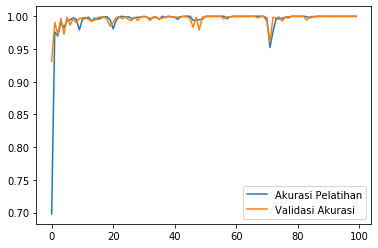

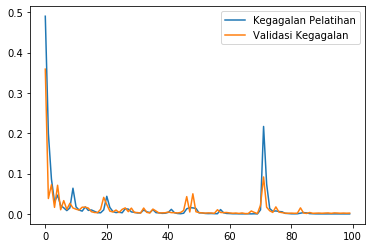

In [37]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kegagalan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kegagalan")
plt.legend()
plt.show()

# Evaluate against Test Data

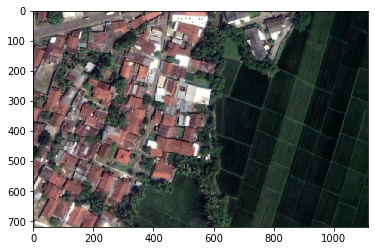

30
1410 30 47


In [38]:
#read test data
img_path = "padi/test/test_image.jpg"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#create subimages
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#check total images, how many images are tiled at height direction, and width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

(1410, 1)
[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.9999957 ]
 [0.99999285]
 [1.        ]]


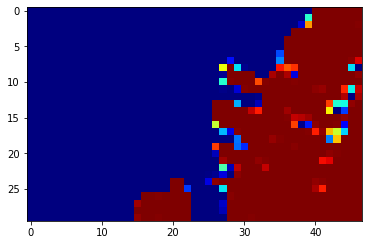

In [39]:
#predict the padi probability for all the cropped images, and reshape back to its original form.
predictions = model.predict(patches)
print(predictions.shape)
print(predictions)

padi = np.reshape(predictions,(n_total//n_x,n_x))
padi = np.rot90(padi)
padi = np.flip(padi,axis=0)
plt.imshow(padi,cmap="jet")

note that each images correspond to 1 pixel of probability, and the size is not compatible with the input images.
we will caculate the ratio factor and resize it.

In [40]:
h_factor = img.shape[0]//padi.shape[0]
w_factor = img.shape[1]//padi.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(padi,(h_factor,w_factor))

print(zoomed.shape)

23
(690, 1081)


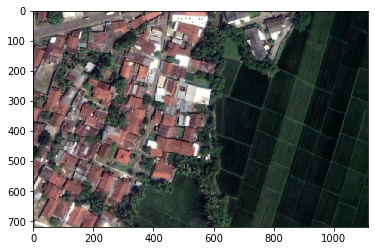

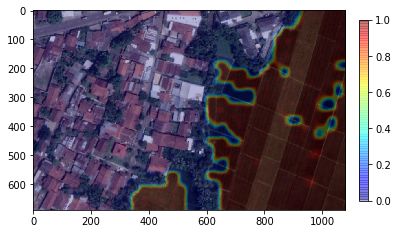

In [41]:
#result
plt.imshow(img)
plt.show()

plt.imshow(img)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()

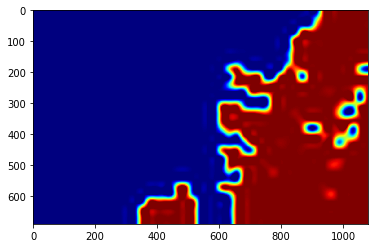

In [42]:
plt.imshow(zoomed,alpha=1,vmax=1.0,vmin=0,cmap="jet")

In [43]:
(zoomed<1).sum()

633730

In [44]:
np.amax(zoomed)

1.3375405

In [45]:
np.amin(zoomed)

-0.2846222